<a href="https://colab.research.google.com/github/parasail-ai/cookbook/blob/main/batch/batch_vlm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Get started with multi-modal batch inference

At Parasail, we support a wide range of state-of-the-art multi-modal model including [LLaVA family](https://huggingface.co/lmms-lab), [Pixtral-12B](https://huggingface.co/mistralai/Pixtral-12B-2409), [Phi-3.5](https://huggingface.co/microsoft/Phi-3.5-vision-instruct) and many others.  All of the multi-modal models are available through OpenAI-compatible batch inference API which is easier to use and cost-effective.

This notebook will walk you through how to use batch inference with multi-modal models.

## Setup



In [ ]:
%pip install openai datasets jsonlines > /dev/null

from IPython.display import display
from collections import defaultdict
from datasets import load_dataset
from io import BytesIO
import base64
import jsonlines
import openai
import time

API key can be obtained on [Parasail platform](https://www.saas.parasail.io/keys).

In [ ]:
client = openai.OpenAI(
    base_url="https://api.saas.parasail.io/v1",
    api_key="psk-API_KEY_HERE",
)

## Load and inspect the data

The dataset used in the example is [PDF-VQA](https://github.com/adlnlp/pdfvqa), which contains PDF document pages and text questions about the elements, structure, and contents of the documents.

Let's first load and inspect the dataset.

Question: Is it correct that there is no table on the left?
Question: Does this page include 2 figure?
Question: Can you find 2 table in the page?
Question: Are there 3 figure in this page?
Question: Can you find a 'introduction' in this page?
Question: What is the topic of left section?
Question: Can you describe the main topic of the bottom section?
Question: What is the bottom left of the page about?
Question: Can you describe the first section of this page?
Question: When you check the last section of this page, what information can you get?


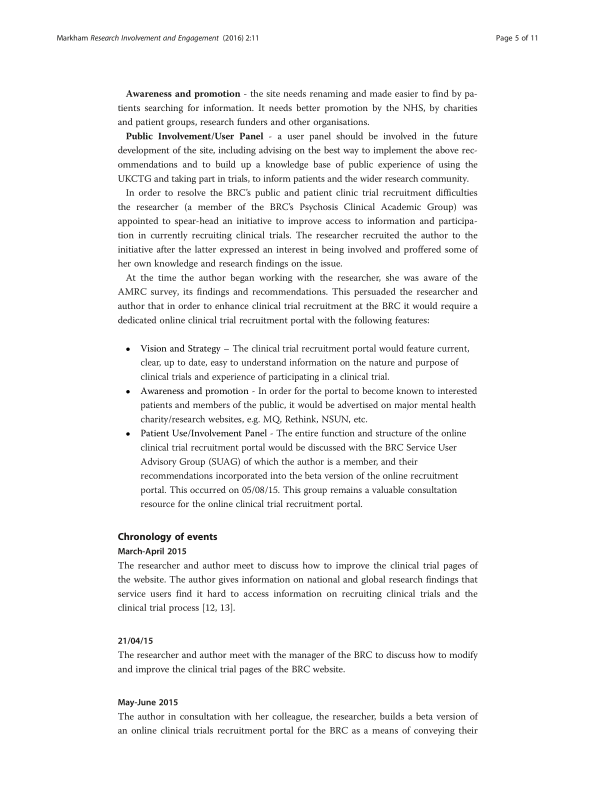

Question: Is there any figure on the bottom left of this page?
Question: How many figures can you find under 'The cell cycle network of Li et al.'?
Question: When you check this page, how many figure can you find below 'The cell cycle network of Li et al.'?
Question: Is it correct that there is no figure under the 'The cell cycle network of Li et al.'?
Question: Is it correct that there is no figure below the 'The cell cycle network of Li et al.'?
Question: How many figures in this page?
Question: Does this page include 1 table?
Question: Are there 1 figure in this page?
Question: Confirm if there is 'results' in this page.
Question: Is there any figure?
Question: What is the top section about?
Question: What is the left of the page about?
Question: What is the top left of the page about?
Question: What is the main contents of the last section in this page?
Question: Can you describe the first section of this page?


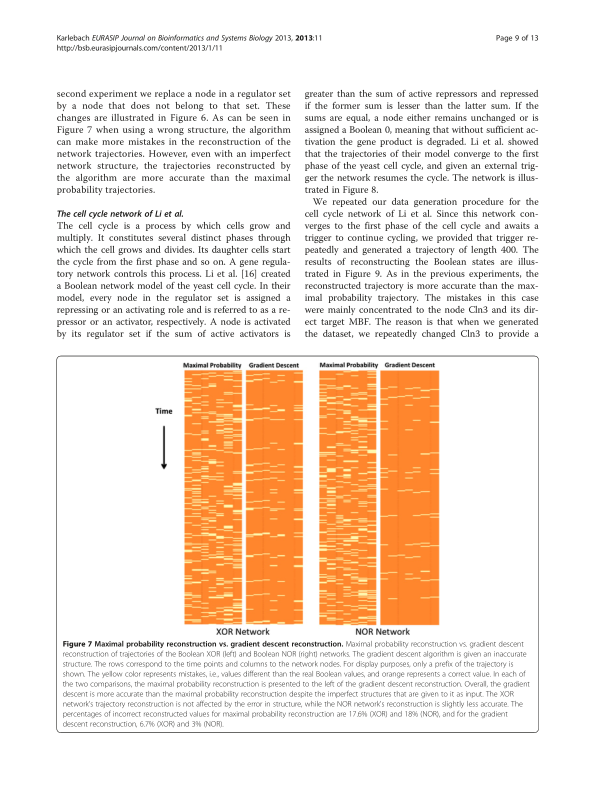

In [ ]:
dataset = load_dataset("gigant/pdfvqa", split='train', streaming=True)
dataset = dataset.shuffle(seed=5)

for doc in dataset.take(2):
  for i, question in enumerate(doc["questions"]):
    if doc["task types"][i] != "C": # Ignore multi-page Type C questions
      print(f"Question: {question}")
  display(doc["page"])

## Create Batch file

The next step is creating a batch request file for the batch job using Pixtral-12B model. The API interface is compatible with [OpenAI Batch API](https://platform.openai.com/docs/guides/batch/overview). Note that images are uploaded with base64 URL.

In [ ]:
# Create requests for 50 documents.
with jsonlines.open('requests.jsonl', mode='w') as writer:
  for doc_i, doc in enumerate(dataset.take(50)):
    for question_i, question in enumerate(doc["questions"]):
      if doc["task types"][question_i] == "C": # Ignore multi-page Type C questions
        continue

      buffer = BytesIO()
      doc["page"].save(buffer, format='JPEG')
      image_url = "data:image/jpeg;base64," + base64.b64encode(buffer.getvalue()).decode("ascii")

      writer.write({
          "custom_id": f"pdfvqa-doc-{doc_i}-q-{question_i}",
          "method": "POST",
          "url": "/v1/chat/completions",
          "body": {
              "model": "mistralai/Pixtral-12B-2409",
              "max_tokens": 256,
              "messages": [
                  {
                      "role": "user",
                      "content": [
                          {
                              "type": "text",
                              "text": f"{question}"
                          },
                          {
                              "type": "image_url",
                              "image_url": {"url": image_url},
                          },
                      ]
                  }
              ],
          }
      })

## Upload Batch file and create batch job

We are now ready to upload the requests file and create a batch job.

In [ ]:
# Upload input file
input_file = client.files.create(file=open("requests.jsonl", "rb"), purpose="batch")

# Create batch job
job = client.batches.create(
    input_file_id=input_file.id,
    completion_window="24h",
    endpoint="/v1/chat/completions",
)
job_id = job.id

print(f"Created job {job_id}")

Created job batch-1siab2eoax


## Retrieve and inspect results

Once the job is completed, we can download the output file.

In [ ]:
# Poll for batch job status
while True:
  job = client.batches.retrieve(job_id)
  print(f"Status of {job_id}: {job.status}")

  if job.status == "completed":
    break

  time.sleep(60)

# Download output file
output = client.files.content(job.output_file_id).content
with open("pdfvqa_batch_output.jsonl", "wb") as file:
  file.write(output)

Status of batch-1siab2eoax: validating
Status of batch-1siab2eoax: in_progress
Status of batch-1siab2eoax: in_progress
Status of batch-1siab2eoax: in_progress
Status of batch-1siab2eoax: in_progress
Status of batch-1siab2eoax: in_progress
Status of batch-1siab2eoax: in_progress
Status of batch-1siab2eoax: in_progress
Status of batch-1siab2eoax: completed


Let's spot check a few responses.

Q: Does this page include 2 figure?
A: No, this page does not include any figures. It contains text
discussing the awareness, promotion, and public involvement in a
clinical trial recruitment site, as well as details about a meeting
between a researcher and an author regarding the improvement of
clinical trial pages on a website.


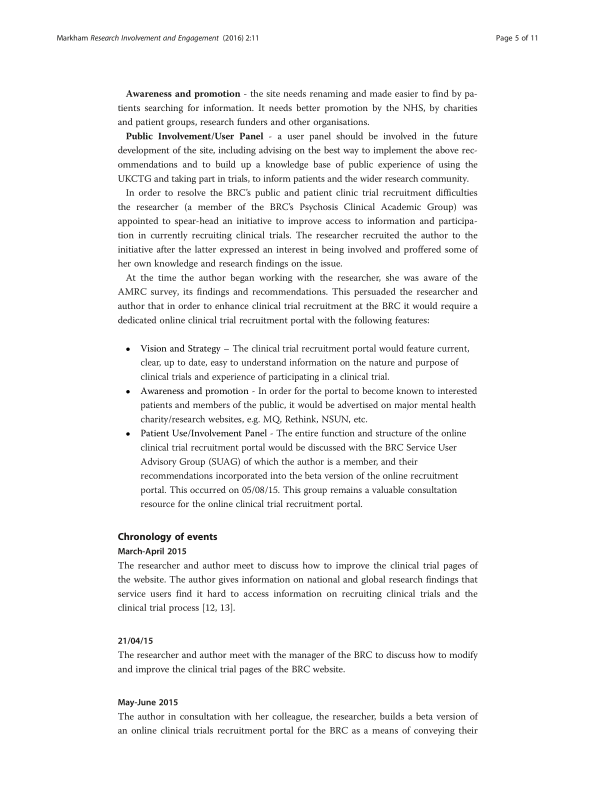

Q: What is the left of the page about?
A: The left side of the page discusses an experiment involving the cell
cycle network of Li et al., which describes the process by which cells
grow and divide. Key points include the role of a gene regulatory
network in controlling the cell cycle, the activation and repression
of nodes by their regulator sets, and the convergence of the cell
cycle network to the first phase given an external trigger. The text
also mentions a comparison between maximal probability reconstruction
and gradient descent reconstruction methods for Booleans, with
references to specific figures and tables illustrating the results.


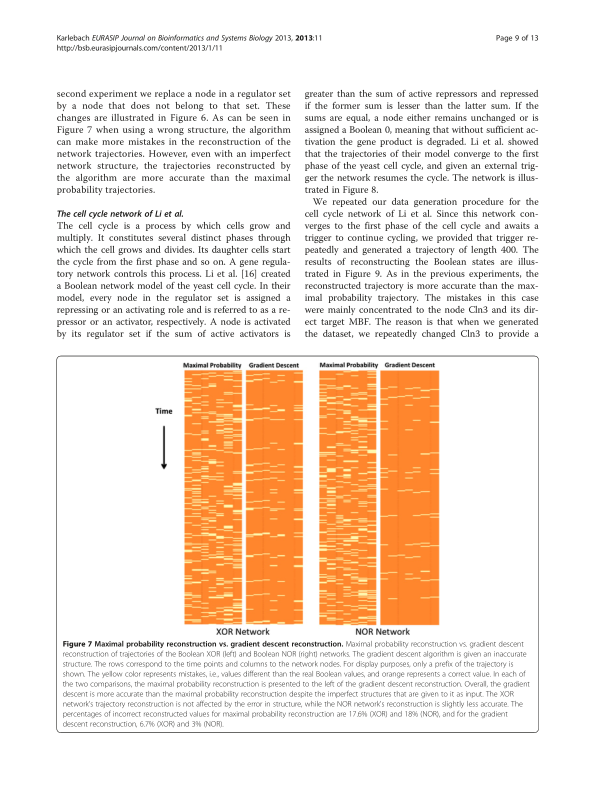

In [ ]:
from textwrap import fill

responses = defaultdict(dict)
with jsonlines.open('pdfvqa_batch_output.jsonl') as reader:
  for resp in reader:
    _, _, doc_i, _, q_i = resp["custom_id"].split("-")
    responses[int(doc_i)][int(q_i)] = resp["response"]["body"]["choices"][0]["message"]["content"]

docs = list(dataset.take(2))

# Example 0
print("Q:", docs[0]["questions"][1])
print("A:", fill(responses[0][1]))
display(docs[0]["page"])

# Example 1
print("Q:", docs[1]["questions"][11])
print("A:", fill(responses[1][11]))
display(docs[1]["page"])